# GIS GZ – Übung 5: Geoprocessing von Rasterdaten  <span style="color:red">(Musterlösung)

## Einleitung
In den letzten Wochen haben Sie gelernt, wie Sie Geodaten mit Fiona verarbeiten können. Heute setzen wir den Fokus auf Rasterioperationen und somit auf die library Rasterio, die in letzter Zeit sehr mächtig geworden ist. Das Ziel der heutigen Übung ist es, aus einem Rasterdatensatz die Lärmemissionen pro Stadtkreis zu ermitteln und diese Information dann in den Stadtkreis-Vektordatensatz zurückzuführen, um die gemittelte Lärmemission pro Kreis darzustellen. 

### Grobziele
* Sie können unterschiedliche Funktionen auf Rasterdaten anwenden, um somit den Nutzen zellbasierter Operationen auszuschöpfen. 

### Feinziele
* Sie können die Funktionsweise von \*args und \**kwargs erklären und in der Praxis anwenden.
* Sie können Datensätze mit Rasterio laden, mit mathematischen Operationen verarbeiten und speichern. 
* Sie können den Rasterdatensatz mit einem Vektordatensatz maskieren. 
* Sie können extrahierte Daten an einen Vektordatensatz hängen und diesen darstellen.

### Projekt
* Sie arbeiten an der Lösung Ihrer Fragestellung und wenden die erlernten Techniken aktiv an. 
* Sie können weitere Werkzeuge von Rasterio auf Ihr Projekt anwenden (z.B. Vektordaten rastern, Raster Algebra-Operationen anwenden, Resamplen und Profil-Einstellungen korrekt setzen).

## Aufgabe 1: Kombinierte Analyse von Raster und Vektordaten

In dieser Aufgabe erhalten Sie drei Dateien:
* `stadtkreise_proj.json` die Stadtkreise der Stadt Zürich
* `strassenlaerm_tag.tif` die Lärmemissionskarte bei Tag
* `strassenlaerm_nacht.tif` die Lärmemissionskarte bei Nacht

Alle Datensätze sind im Landeskoordinatensystem CH1903+/LV95 gespeichert. 
Führen Sie zunächst die Funktion show_input_map(filename) aus, um den Datensatz zu sehen. Sie werden merken, dass das Raster rechteckförmig ausgeschnitten ist. 
Benutzen Sie die Vektordaten (Stadtkreise, aber auch die Grenzen der ganzen Stadt Zürich), um die Werte der einzelnen Kreise zu extrahieren und die Werte auf dem Raster zu maskieren.

Der folgende Code enthält 3 Stellen, an denen Sie Zeilen ergänzen sollen:
* TODO(1) in `calculate_average_noise()`: Berechnen Sie den Durchschnittswert des Rasters (nur nonzero-Werte) für alle Stadtkreise und fügen Sie die Werte in eine Liste ein.
* TODO(2) in save_map(open_file, save_file, average_noise_by_kreis): Erstellen Sie ein neues Shapefile indem sie das alte verwenden und um das zusätzliche Attribut 'avg_strassenlaerm_tag' erweitern. Fügen Sie dann die Werte aus TODO(1) ein.
* TODO(3) am Ende: Zeigen Sie das neue Shapefile als Choroplethenkarte über das Attribut 'avg_strassenlaerm_tag' an, verwenden Sie dafür show_result_map(filename, attribute).

### Verwendete libraries und Funktionen

Zuerst importieren wir die nötigen libraries der heutigen Übung. Standardmässig verwenden wir für `numpy`, `pandas` und `matplotlib` Abkürzungen.

In [1]:
import os
import rasterio
import rasterio.mask
from rasterio.plot import show
import fiona
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### Definieren wichtiger Pfade und Ordner

In [2]:
# define important directories
data_dir = os.path.join(os.path.abspath(''), 'data')
out_dir = os.path.join(os.path.abspath(''), 'results')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Zusatzfunktion zum Plotten des Eingabe Datensatzes

In [3]:
def show_input_map(path_to_file):
    """
    Loads and plots the raster data
    :param path_to_file: Path to the GeoTiff with one band
    :return:
    """
    
    plt.figure(figsize=(20, 20))
    raster = rasterio.open(path_to_file)
    plt.imshow(raster.read(1), cmap='hot')
    plt.show()
    raster.close()

### Zusatzfunktion zum Plotten der Resultate

In [4]:
def show_result_map(filename, attribute):
    """
    Plots the map of Zurich with the average noise value
    :param filename: Shapefile that will be drawn.
    :param attribute: Attribute that will be used to create a choropleth map.
    :return:
    """
    
    vector_map = gpd.read_file(filename)
    vector_map.plot(column=attribute)
    plt.show()

### Funktion zur Berechnung der Lärmmittelwerte pro Kreis

#### Aufgabe 
Berechnen Sie den Durchschnittswert des Rasters (nur nonzero-Werte) für alle Stadtkreise und fügen Sie die Werte in die Liste `average_noise_by_kreis` ein. Diese Liste wird dann an die Hauptfunktion `main()` zurückgegeben.

In [5]:
def calculate_average_noise(path_to_input_raster, shapes):
    """
    Calculates the average noise per Stadtkreis and returns a list with all noise values
    :param path_to_input_raster: The path to the input raster
    :param shapes: The extracted geometries from the vector layer that should be used as mask
    :return: A list with the average noise per Stadtkreis, depending on the input raster and on the shapes
    """

    # calculate the average value from the input raster for each Polygon
    average_noise_by_kreis = list()
    with rasterio.open(path_to_input_raster, 'r') as src:
        for stadt_kreis in shapes:
            kreis = list()
            kreis.append(stadt_kreis)

            # mask the raster based on the shape of the Stadtkreis
            out_i, out_t = rasterio.mask.mask(src, kreis, crop=True)

            ###############################################################################################
            #
            # TODO (1): calculate the mean of all nonzero values and insert it in average_noise_by_kreis list
            #
            ###############################################################################################

    return average_noise_by_kreis

### Speicherfunktion für neues Shapefile mit zusätzlichen Attributen

Beachten Sie, dass beim letzten übergebenen Argument `schema_info_and_record` ein Stern steht. Das bedeutet, dass alles, was ab dieser Position folgt, in eine Liste gespeichert wird, die als Ganzes an die Funktion übegeben wird. Beachten Sie ebenso, wie wir das Schema ändern, um die beiden neuen Attribute für das output file festzulegen: Wir iterieren durch die Einträge in `*schema_info_and_record` und ziehen daraus die values, die unter den keys `attribute_name` und `data_type` gespeichert sind.  

In [6]:
def save_map_solution(open_file, save_file, *schema_info_and_record):
    """
    Saves a new json file and extends the structure by the values passed with average noise values
    :param open_file: The path to the GeoJSON file that has to be extended.
    :param save_file: The path to the GeoJSON file that should be written.
    :param dict schema_info_and_record: A dictionary containing the schema metainformation and the record
    :return:
    """

    for entry in schema_info_and_record:
        if len(entry['record']) == 0:
            print('Empty list provided! Check the function calculate_average_noise()!')
            return

    with fiona.open(open_file, 'r') as shapefile:
        driver = shapefile.driver
        crs = shapefile.crs
        schema = shapefile.schema.copy()

        # Extend the schema by the entries passed in the dictionaries
        for j in schema_info_and_record:
            schema['properties'][j['attribute_name']] = j['data_type']

        # Open the output file
        with fiona.open(save_file,
                        'w',
                        schema=schema,
                        driver=driver,
                        crs=crs) as tgt:

            # Iterate through the entries in the input file, iterate through
            # the entries in the dictionaries and append the record to the
            # according attribute. Then, write the record to the file.
            for num, i in enumerate(shapefile):
                for j in schema_info_and_record:
                    i['properties'][j['attribute_name']] = j['record'][num]
                tgt.write(i)
    return

### Hauptfunktion
Bitte beachten Sie, dass das Ausgabefile in den Ausgabeordner `out_dir` gespeichert wird.

In [7]:
def main_solution():
    
    # load shape file
    with fiona.open(os.path.join(data_dir, 'stadtkreise_proj.json'), 'r') as shapefile:
        shapes = [feature['geometry'] for feature in shapefile]

    # calculate the average value from the night raster for each Polygon
    average_noise_by_kreis_day = calculate_average_noise_solution(os.path.join(data_dir, 'strassenlaerm_tag.tif'), shapes)
    average_noise_by_kreis_night = calculate_average_noise_solution(os.path.join(data_dir, 'strassenlaerm_nacht.tif'), shapes)

    print(average_noise_by_kreis_day)
    print(average_noise_by_kreis_night)

    # Define the input and the output path and define a dictionary that contains metadata and
    # records for the attributes that will be written to the output file.
    # Then, write the attributes to the new file.
    open_file = os.path.join(data_dir, 'stadtkreise_proj.json')
    save_file = os.path.join(out_dir, 'stadtkreise_proj_extended.json')
    schema_info_and_record_day = {'attribute_name': 'avg_strassenlaerm_tag',
                                  'data_type': 'float',
                                  'record': average_noise_by_kreis_day}
    schema_info_and_record_night = {'attribute_name': 'avg_strassenlaerm_nacht',
                                    'data_type': 'float',
                                    'record': average_noise_by_kreis_night}
    save_map_solution(open_file, save_file, schema_info_and_record_day, schema_info_and_record_night)

Wenn Sie alles richtig gemacht haben, dann sollten Sie folgendes Ergebnis erhalten:

[44.97185046090816, 57.328845037724896, 52.58689073236729, 46.99835073110883, 45.82737294675339, 46.47697149536912, 49.57169895262297, 46.781905357515114, 47.003428846795416, 43.05626447131464, 43.35306819734864, 54.9924973204716]

[36.67721140199381, 48.46401625072548, 43.95136540036316, 37.18198473897199, 37.22912578547018, 38.1394244656268, 40.546272348190655, 37.63277048155097, 38.40573686657368, 34.140345198171715, 33.50567467919009, 46.02020364415863]

### Darstellen der Resultate

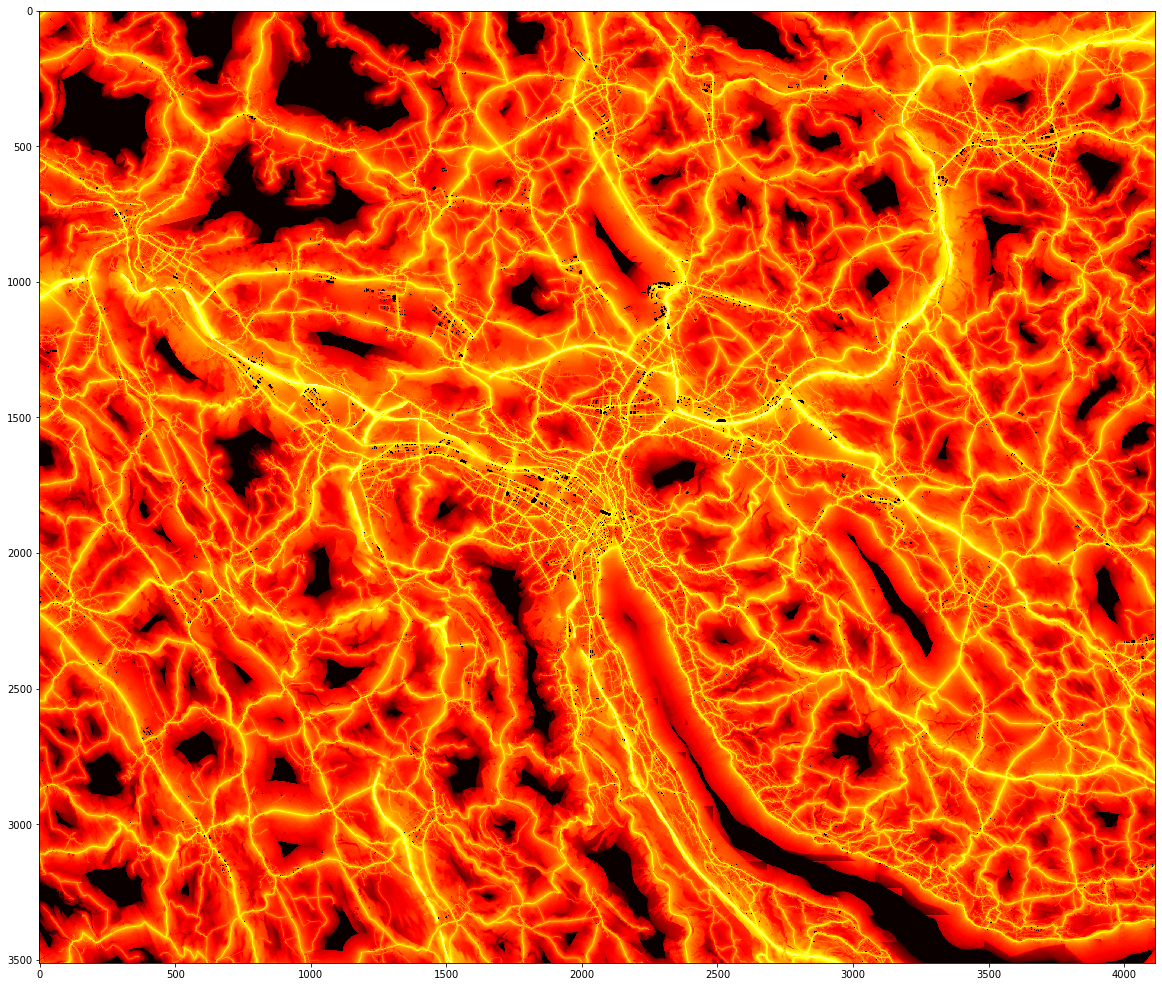

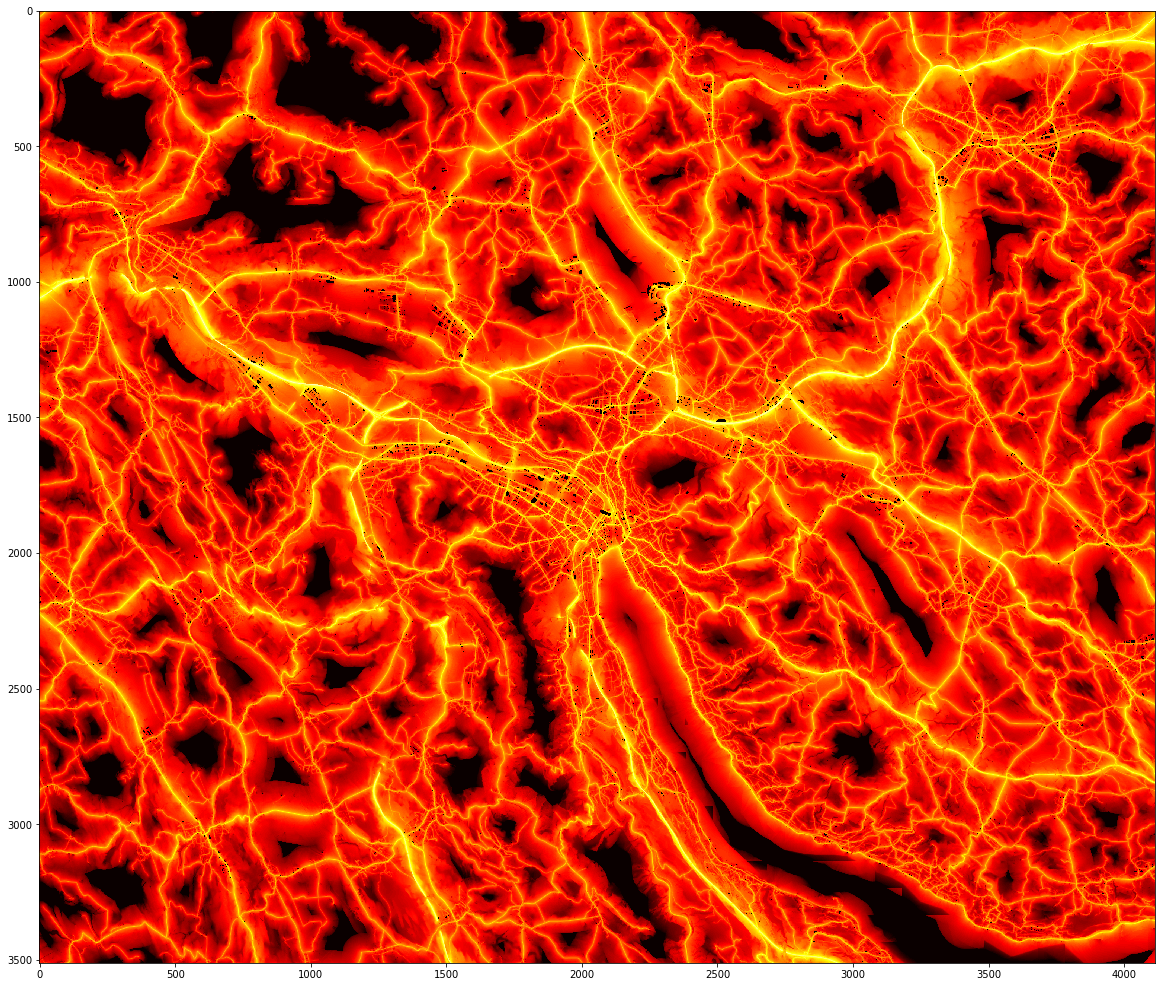

In [8]:
#show the dataset
show_input_map(os.path.join(data_dir, 'strassenlaerm_tag.tif'))
show_input_map(os.path.join(data_dir, 'strassenlaerm_nacht.tif'))

Zeigen Sie das neue Shapefile als Choroplethenkarte über das Attribut 'avg_strassenlaerm_tag' an und verwenden Sie dafür show_result_map(filename, attribute).

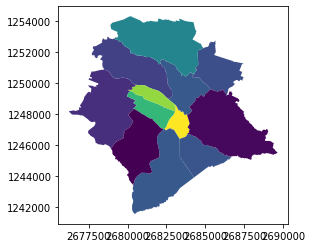

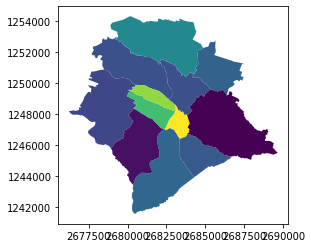

In [9]:
# Show the calculated result, each for the noise during the day and during the night on a choropleth map.
show_result_map(os.path.join(out_dir, 'stadtkreise_proj_extended.json'), 'avg_strassenlaerm_tag')
show_result_map(os.path.join(out_dir, 'stadtkreise_proj_extended.json'), 'avg_strassenlaerm_nacht')

## Aufgabe: Vergleichen Sie die Resultate
Vergleichen Sie die Resultate zwischen dem Lärm während dem Tag und während der Nacht. Inwiefern unterscheiden sich die Werte? Wie wird das auf den Karten dargestellt? Finden Sie die Darstellung geeignet? Wenn nicht, was müsste man ändern? Wie könnte man das programmiertechnisch ändern?

<font color='orange'>Die Werte unterscheiden sich zwischen Tag und Nacht um ca. 8-11 Einheiten, aber die Differenz ist relativ konstant. In der Rasterkarte sieht man, dass abseits der stark befahrenen Gebiete der Lärm nach aussen etwas nachlässt. Die Farbwerte hingegen wurden jeweils auf das relative Minimum und Maximum im Bild bzw. im Datenarray angepasst, sprich normalisiert. Das ist irreführend, da somit die wahre Lärmdifferenz zwischen Tag und Nacht nicht ersichtlich ist. Dies ist sowohl auf den Rastern als auch auf den Choroplethenkarten ersichtlich. Dies könnte man damit ändern, dass für beide Zustände (Tag und Nacht) das globale Min/Max ermittelt wird und die Farbwerte entsprechend diesen globalen Min/Max-Werten dargestellt werden.</font>

# Erkenntnisse

Mit grosser Wahrscheinlichkeit beinhaltete die heutige Übung viel Neues für Sie. Welche Parameter konnten Sie modellieren, welche nicht? Notieren Sie im anschliessenden Feld Ihre wichtigsten Erkenntnisse von heute:

*[Ihre Notizen]*

# Projekt
Arbeiten Sie am Projekt weiter und wenden Sie das, was Sie heute gelernt haben, auf Ihr Projekt an. Gehen Sie auch die weiteren Methoden durch, die Ihnen Rasterio zur Verfügung stellt. Rasterio ist eine sehr mächtiges Rasterverarbeitungslibrary, die sehr viele Anwendungen zulässt.